# How to work with Climate Adaptation Digital Twin data on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the `SSP3-7.0-IFS-NEMO-sfc-standard-v0.zarr` datset on Earth Data Hub. This is a sample dataset for the Destine Climate Adaptation Digital Twin.

Our first goal is to plot the mean 2 metre temperature in January 2030 over Central Europe.

Our second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2030 reference period.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine data.earthdatahub.com
#   login {your_username}
#   password {your_password}

ds = xr.open_dataset(
    "https://data.earthdatahub.com/destine-climate-dt/SSP3-7.0-IFS-NEMO-sfc-standard-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

<xarray.Dataset> Size: 2TB
Dimensions:            (time: 96432, latitude: 512, longitude: 1025)
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 4kB -90.0 -89.65 -89.3 ... 89.65 90.0
  * longitude          (longitude) float64 8kB -180.0 -179.6 ... 179.6 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 771kB 2020-01-01 ... 2030-12-31T...
Data variables:
    d2m                (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    msl                (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    sp                 (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    tclw               (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    tcwv               (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 202GB dask.array<chunksize=(576, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-03-23T10:52 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: average January 2030 in Germany

### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 96432, latitude: 23, longitude: 31)> Size: 275MB
dask.array<getitem, shape=(96432, 23, 31), dtype=float32, chunksize=(576, 23, 31), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 184B 47.03 47.38 47.73 ... 54.42 54.77
  * longitude          (longitude) float64 248B 5.273 5.625 ... 15.47 15.82
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 771kB 2020-01-01 ... 2030-12-31T...
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select January 2030. This is again a lazy operation:

In [3]:
t2m_germany_area_january_2030 = t2m_germany_area.sel(time="2030-01")
t2m_germany_area_january_2030

<xarray.DataArray 't2m' (time: 744, latitude: 23, longitude: 31)> Size: 2MB
dask.array<getitem, shape=(744, 23, 31), dtype=float32, chunksize=(456, 23, 31), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 184B 47.03 47.38 47.73 ... 54.42 54.77
  * longitude          (longitude) float64 248B 5.273 5.625 ... 15.47 15.82
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 6kB 2030-01-01 ... 2030-01-31T23...
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_germany_area_january_2030 = t2m_germany_area_january_2030.compute()

CPU times: user 2.29 s, sys: 786 ms, total: 3.07 s
Wall time: 13.2 s


The data was very small, this didn't take long.

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_january_2030_monthly_mean = t2m_germany_area_january_2030.mean(dim="time")
t2m_germany_area_january_2030_monthly_mean

<xarray.DataArray 't2m' (latitude: 23, longitude: 31)> Size: 3kB
array([[ 3.2780864 ,  3.2989204 ,  3.2989204 , -0.48366997, -0.48366997,
         2.3184028 ,  1.1924094 ,  1.6131026 , -0.4460353 , -0.4460353 ,
        -3.570335  , -3.570335  , -3.4984286 , -3.4984286 , -4.8089004 ,
        -4.8089004 , -3.2087944 , -5.9641404 , -5.9641404 , -8.944636  ,
        -8.944636  , -5.4930434 , -5.4930434 , -4.9449983 , -4.9449983 ,
        -3.931228  , -1.6731911 , -1.6731911 ,  0.06303766,  0.06303766,
         0.07849769],
       [ 2.945758  ,  2.9780166 ,  2.9780166 ,  2.3184028 ,  2.3184028 ,
         2.3184028 ,  1.6131026 ,  1.6131026 ,  1.5895855 ,  1.5895855 ,
         0.5529631 ,  0.5529631 , -0.86976606, -0.86976606, -0.86976606,
        -3.2087944 , -3.2087944 , -4.7101154 , -4.7101154 , -3.0041556 ,
        -3.0041556 , -2.9211628 , -2.9211628 , -2.9211628 , -3.931228  ,
        -3.931228  , -5.6331654 , -5.6331654 , -2.2424133 , -2.2424133 ,
         0.05128163],
       [ 2.588899  ,  2.672233  ,  2.672233  ,  2.672233  ,  1.9259292 ,
         1.9259292 ,  3.2145772 ,  3.2145772 ,  0.8953674 ,  0.8953674 ,
         0.5529631 ,  1.773384  ,  1.773384  , -0.2598833 , -0.2598833 ,
        -0.3737955 , -0.3737955 , -1.0996068 , -1.0996068 , -3.0041556 ,
        -0.74409026, -0.74409026, -0.0780853 , -0.0780853 , -1.7229245 ,
        -1.7229245 , -1.9362988 , -1.9362988 , -1.9362988 , -3.5273447 ,
...
         5.5123496 ,  5.719341  ,  4.801657  ,  4.801657  ,  3.34059   ,
         3.34059   ,  3.3244593 ,  2.6436656 ,  2.6436656 ,  2.7780743 ,
         2.45919   ,  3.0532827 ,  2.1389618 ,  2.1389618 ,  2.986413  ,
         1.9514621 ,  1.9514621 ,  2.3116763 ,  1.7454813 ,  2.3419187 ,
         2.179284  ,  2.179284  ,  2.738087  ,  1.1127578 ,  1.1127578 ,
         2.7911794 ],
       [ 6.356105  ,  6.3766026 ,  6.0614123 ,  6.0614123 ,  5.719341  ,
         5.719341  ,  5.7126217 ,  5.092657  ,  5.092657  ,  4.947831  ,
         3.3244593 ,  3.3244593 ,  2.7780743 ,  2.7780743 ,  3.1033502 ,
         3.0532827 ,  3.0532827 ,  3.1329215 ,  2.986413  ,  2.986413  ,
         2.3116763 ,  2.3116763 ,  3.0072467 ,  2.3419187 ,  2.3419187 ,
         3.1164558 ,  2.738087  ,  2.738087  ,  2.7911794 ,  2.7911794 ,
         3.4971826 ],
       [ 6.3766026 ,  6.379291  ,  6.0694776 ,  6.0694776 ,  5.7126217 ,
         5.7126217 ,  5.7126217 ,  4.947831  ,  4.947831  ,  4.827535  ,
         3.3389099 ,  3.3389099 ,  3.1033502 ,  3.1033502 ,  3.1033502 ,
         3.1329215 ,  3.1329215 ,  3.1329215 ,  2.7310307 ,  2.7310307 ,
         2.4168506 ,  3.0072467 ,  3.0072467 ,  3.1164558 ,  3.1164558 ,
         3.1164558 ,  3.3792338 ,  3.3792338 ,  2.1023347 ,  3.4971826 ,
         3.4971826 ]], dtype=float32)
Coordinates:
    heightAboveGround  float64 8B 2.0
  * latitude           (latitude) float64 184B 47.03 47.38 47.73 ... 54.42 54.77
  * longitude          (longitude) float64 248B 5.273 5.625 ... 15.47 15.82
    step               timedelta64[ns] 8B 00:00:00
    surface            float64 8B 0.0

### 3. Visualization
Finally, we can plot the january 2030 montly mean on a map:

In [6]:
import display
import matplotlib.pyplot as plt

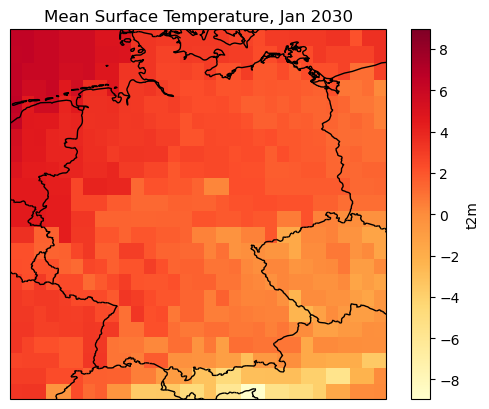

In [7]:
display.map(t2m_germany_area_january_2030_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Jan 2030")

## 2020-2030 climatology

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin, over the reference period 2020-2030

We first select the closet data to Berlin:

In [8]:
%%time

t2m_Berlin = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest")
t2m_Berlin

CPU times: user 6.94 ms, sys: 2.94 ms, total: 9.87 ms
Wall time: 1.45 ms


<xarray.DataArray 't2m' (time: 96432)> Size: 386kB
dask.array<getitem, shape=(96432,), dtype=float32, chunksize=(576,), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
    latitude           float64 8B 52.66
    longitude          float64 8B 13.36
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 771kB 2020-01-01 ... 2030-12-31T...
Attributes:
    units:    C

This is already small enought to be computed:

In [9]:
%%time

t2m_Berlin = t2m_Berlin.compute()

KeyboardInterrupt: 

Now that the data is loaded in memory we can easily compute the climatology for the reference period 2020-2030:

In [10]:
t2m_Berlin_climatology_mean = t2m_Berlin.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin.groupby("time.month").std(dim="time")

We can finally plot the climatology in Berlin for the 2020-2030 refrence period

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


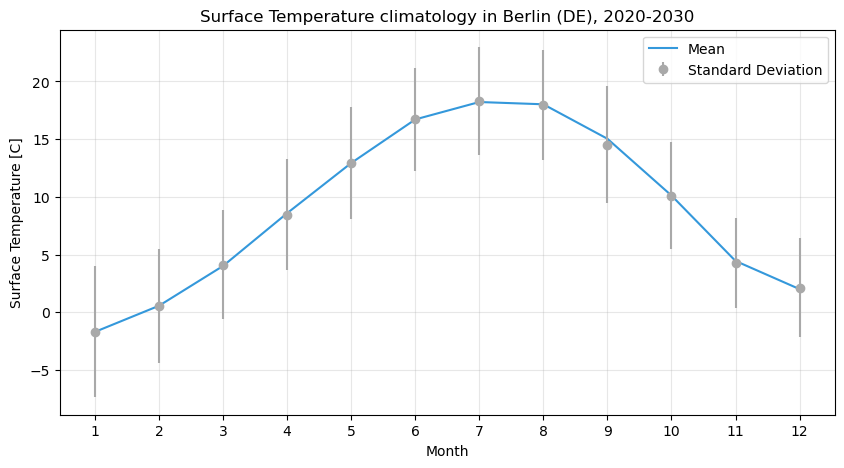

In [11]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2030")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()